# OpenMC: Scripting

Please indicate your name below, since you will need to submit this notebook completed latest the day after the datalab.

Don't forget to save your progress during the datalab to avoid any loss due to crashes.

In [1]:
name='Jeppe'

**Note** you will need to run Jupyter from an environment where openMC is available in order to run this notebook!

During the first openMC datalab, we have covered the basics, and covered how to write a basic input, how to run it and how to post-process the results. Today we go one step further and will explore the real power of the python API. Namely that we can automatize calculations simply by defining a function which creates the input for us. Then we can write loops and automatically update our model. For this we will use the `Model()` class of openMC. This basically means that instead of exporting all the details of the run into xml, openMC will take care of this, when we call the `.run()` method of the class.

We will learn about

- the built in criticality search functionality of openMC (which is a wrapper for the scipy.optimization methods).
- write our own script to determine the void-coefficient change of the LWR pincell at various fuel to moderator ratio
- will write a tally to investigate the fuel utilization factor and the resonance escape probability.

Let's get started with doing the necessary imports!

In [2]:
import openmc
import openmc.model
import numpy as np
import matplotlib.pyplot as plt
import os

path = r"/root/jeff-3.3-hdf5/cross_sections.xml"


## Experiment 1

First we will calculate the boron concentration at which the k-infinity of the pincell is 1.2. For a finite core, of course usually we would like to know the critical boron content, but now we have reflective boundaries (ie. no leakage), so for the demonstration we aim for higher than 1.0 multiplication factor.

First, we will define the `pincell()` function. The expressions inside this function are probably similar from the previous datalab. We only did some small changes:
- we have decreased the number of particles per batch: although we will have a worse accuracy, but we will need to run this input several times, and it is not sustainable to spend the datalab with waiting for the calculations to finish
- we have not included a numeric ID for the `Material()` instances. In this case openMC will increment the ID number. Since in these examples we do not use the IDs for anything, we can live without controlling it. (If we kept the ID, openMC would send a warning all the time that the ID was already in use. It is a warning, so not an error, but still annoying).
- we have added a small amount of boron to the water (in reality boric acid is added to the water)
- we have removed the calls to the `export_to_xml()` methods.
- since we removed the tallies, we included `settings.output = {'tallies': False}` (this is to make sure that in case a 'tallies.xml' file is present from an other run it is not used)
- finally, at the end we create an instance `model = openmc.model.Model(geom, mats, settings)` and return it.

In [3]:
def pincell(bppm):
    uo2 = openmc.Material(name="uo2",temperature=1200)
    # Adding nuclides to uo2
    uo2.add_nuclide('U235', 0.04)
    uo2.add_nuclide('U238', 0.96)
    uo2.add_nuclide('O16', 2.0)
    uo2.set_density('g/cm3', 10.5)


    #cladding
    zirconium = openmc.Material(name="zirconium",temperature=900)
    zirconium.add_element('Zr', 1.0)
    zirconium.set_density('g/cm3', 6.6)

    #coolant
    water = openmc.Material(name="h2o")
    water.add_nuclide('H1', 2.0)
    water.add_nuclide('O16', 1.0)
    water.set_density('g/cm3', 0.74)
    #THIS IS THE IMPORTANT NEW LINE COMPARED TO BEFORE!
    water.add_element('B', bppm*1e-6) 
    ###################################################
    water.add_s_alpha_beta('c_H_in_H2O')

    mats = openmc.Materials([uo2, zirconium, water])
    mats.cross_sections = path


    fuel_or = openmc.ZCylinder(r=0.41) #fuel cylinder with outer radius
    clad_ir = openmc.ZCylinder(r=0.42) #clad inner cylinder with inner radius
    clad_or = openmc.ZCylinder(r=0.45) #clad outer cylinder with outer radius

    fuel_region = -fuel_or                  #inside the fuel cylinder
    gap_region = +fuel_or & -clad_ir      #outside of fuel cylinder and inside of clad inner cylinder
    clad_region = +clad_ir & -clad_or     #outside of clad inner cylinder and inside of clad outer cylinder

    fuel = openmc.Cell(name='fuel')
    fuel.fill = uo2
    fuel.region = fuel_region

    gap = openmc.Cell(name='air gap')
    gap.region = gap_region

    clad = openmc.Cell(name='clad')
    clad.fill = zirconium
    clad.region = clad_region

    pitch = 1.26
    #we define the x and y planes with boundary condition
    left = openmc.XPlane(x0=-pitch/2, boundary_type='reflective')
    right = openmc.XPlane(x0=pitch/2, boundary_type='reflective')
    bottom = openmc.YPlane(y0=-pitch/2, boundary_type='reflective')
    top = openmc.YPlane(y0=pitch/2, boundary_type='reflective')

    #outside of left and inside of right, outside of bottom, and inside of top and outside of clad outer cylinder
    water_region = +left & -right & +bottom & -top & +clad_or

    moderator = openmc.Cell(name='moderator')
    moderator.fill = water
    moderator.region = water_region

    root = openmc.Universe(cells=(fuel, gap, clad, moderator))

    geom = openmc.Geometry()
    geom.root_universe = root

    point = openmc.stats.Point((0, 0, 0))
    src = openmc.Source(space=point)

    settings = openmc.Settings()
    settings.source = src
    settings.batches = 100
    settings.inactive = 10
    settings.particles = 500
    settings.output = {'tallies': False}

    model = openmc.model.Model(geom, mats, settings)
    return model

Now we can perform a search for the boron concentration at which the multiplication factor is 1.2. This is a fairly similar root finding problem that we have done in datalab 5. In fact, if you look into the [source code](https://docs.openmc.org/en/stable/_modules/openmc/search.html#search_for_keff) of `openmc.search_for_keff` you will see that the function wraps the methods of scipy.optimize. 

We will need to pass as an input the function `pincell`, we can specify the lower and upper bound of the boron content to limit the interval of the search, and set the tolerance (ie. how accurate we want to be with the desired multiplication factor). The search will need some time, so while you wait you can start reading the next experiment!

In [4]:
os.system('rm *h5')
crit_ppm, guesses, keffs = openmc.search_for_keff(pincell, target=1.2, bracket=[2000., 3500.],
                                                  tol=1e-2, print_iterations=False)

print('Critical Boron Concentration: {:4.0f} ppm'.format(crit_ppm))

rm: cannot remove '*h5': No such file or directory
/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


 Reading U238 from /root/jeff-3.3-hdf5/U238.h5
 Reading O16 from /root/jeff-3.3-hdf5/O16.h5
 Reading Zr90 from /root/jeff-3.3-hdf5/Zr90.h5
 Reading Zr91 from /root/jeff-3.3-hdf5/Zr91.h5
 Reading Zr92 from /root/jeff-3.3-hdf5/Zr92.h5
 Reading Zr94 from /root/jeff-3.3-hdf5/Zr94.h5
 Reading Zr96 from /root/jeff-3.3-hdf5/Zr96.h5
 Reading H1 from /root/jeff-3.3-hdf5/H1.h5
 Reading B10 from /root/jeff-3.3-hdf5/B10.h5
 Reading B11 from /root/jeff-3.3-hdf5/B11.h5
 Reading c_H_in_H2O from /root/jeff-3.3-hdf5/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 1200 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for H1
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.10001
        2/1    1.14934
        3/1    1.23577
       

/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


 Reading U238 from /root/jeff-3.3-hdf5/U238.h5
 Reading O16 from /root/jeff-3.3-hdf5/O16.h5
 Reading Zr90 from /root/jeff-3.3-hdf5/Zr90.h5
 Reading Zr91 from /root/jeff-3.3-hdf5/Zr91.h5
 Reading Zr92 from /root/jeff-3.3-hdf5/Zr92.h5
 Reading Zr94 from /root/jeff-3.3-hdf5/Zr94.h5
 Reading Zr96 from /root/jeff-3.3-hdf5/Zr96.h5
 Reading H1 from /root/jeff-3.3-hdf5/H1.h5
 Reading B10 from /root/jeff-3.3-hdf5/B10.h5
 Reading B11 from /root/jeff-3.3-hdf5/B11.h5
 Reading c_H_in_H2O from /root/jeff-3.3-hdf5/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 1200 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for H1
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.13935
        2/1    1.20825
        3/1    1.17646
       

/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


 Reading U238 from /root/jeff-3.3-hdf5/U238.h5
 Reading O16 from /root/jeff-3.3-hdf5/O16.h5
 Reading Zr90 from /root/jeff-3.3-hdf5/Zr90.h5
 Reading Zr91 from /root/jeff-3.3-hdf5/Zr91.h5
 Reading Zr92 from /root/jeff-3.3-hdf5/Zr92.h5
 Reading Zr94 from /root/jeff-3.3-hdf5/Zr94.h5
 Reading Zr96 from /root/jeff-3.3-hdf5/Zr96.h5
 Reading H1 from /root/jeff-3.3-hdf5/H1.h5
 Reading B10 from /root/jeff-3.3-hdf5/B10.h5
 Reading B11 from /root/jeff-3.3-hdf5/B11.h5
 Reading c_H_in_H2O from /root/jeff-3.3-hdf5/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 1200 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for H1
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.10646
        2/1    1.25757
        3/1    1.30069
       

/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


 Reading U238 from /root/jeff-3.3-hdf5/U238.h5
 Reading O16 from /root/jeff-3.3-hdf5/O16.h5
 Reading Zr90 from /root/jeff-3.3-hdf5/Zr90.h5
 Reading Zr91 from /root/jeff-3.3-hdf5/Zr91.h5
 Reading Zr92 from /root/jeff-3.3-hdf5/Zr92.h5
 Reading Zr94 from /root/jeff-3.3-hdf5/Zr94.h5
 Reading Zr96 from /root/jeff-3.3-hdf5/Zr96.h5
 Reading H1 from /root/jeff-3.3-hdf5/H1.h5
 Reading B10 from /root/jeff-3.3-hdf5/B10.h5
 Reading B11 from /root/jeff-3.3-hdf5/B11.h5
 Reading c_H_in_H2O from /root/jeff-3.3-hdf5/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 1200 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for H1
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.11099
        2/1    1.19137
        3/1    1.20304
       

We can visualize the guesses by the optimization algorithm, and see how the boron content converged to the correct amount.

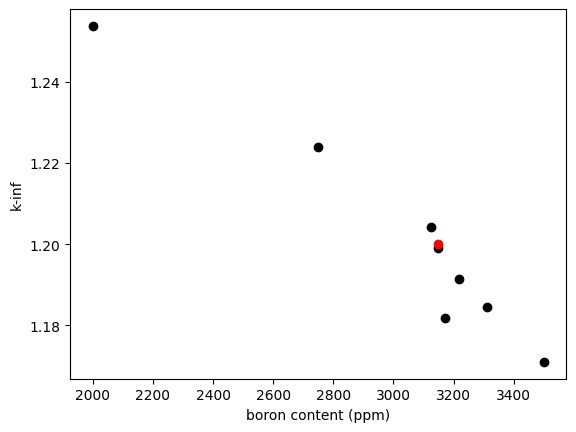

In [5]:
plt.figure()
for g,k in zip(guesses,keffs):
    plt.scatter(g,k.nominal_value,color='k')
plt.xlabel('boron content (ppm)')
plt.ylabel('k-inf')
plt.scatter(crit_ppm,1.2,color='r')
plt.show()

## Experiment 2

During the lectures we have learnt about the reactivity feedback coefficients. Today we are going to investigate the void coefficient for various moderator to fuel ratios. The moderator to fuel ratio can be defined in the rectangular pincell as

$$mfr=\frac{p^2-r_{clad}^2\pi}{r_{fuel}^2\pi}$$

can be simply modified by changing the pitch $p$.

The void constant of the fuel can be modified by changing the density of the coolant. We can use the following simple relationship:

$$\rho_{coolant}=\rho_0(1-void[\%]/100)$$

where $\rho_0=0.74$ g/cm3. In practice, of course we will never obtain a zero density even for a fully voided core. Also, it is worth mentioning that void levels investigated here are never reached in normal operations for a PWR, but are however the nominal levels for a BWR. Nevertheless, the goal of the exercise is not to investigate exact reactor operation scenarios, rather to provide a physicist insight for understanding how significantly lowering the density of the moderator affects the multiplication factor.

First create a `pincell()` function where the user can modify the pitch and the void content. The function should return a `Model()` object. (You do not need to include boron in the coolant for this exercise).

In [6]:
def pincell(pitch,void,r_clad_out, r_clad_in, r_fuel):
    uo2 = openmc.Material(name="uo2",temperature=1200)
    # Adding nuclides to uo2
    uo2.add_nuclide('U235', 0.04)
    uo2.add_nuclide('U238', 0.96)
    uo2.add_nuclide('O16', 2.0)
    uo2.set_density('g/cm3', 10.5)

    #cladding
    zirconium = openmc.Material(name="zirconium",temperature=900)
    zirconium.add_element('Zr', 1.0)
    zirconium.set_density('g/cm3', 6.6)
    
    #coolant
    rho_coolant = 0.74*(1-void/100)
    
    water = openmc.Material(name="h2o")
    water.add_nuclide('H1', 2.0)
    water.add_nuclide('O16', 1.0)
    water.set_density('g/cm3', rho_coolant)
    water.add_s_alpha_beta('c_H_in_H2O')

    mats = openmc.Materials([uo2, zirconium, water])
    mats.cross_sections = path


    fuel_or = openmc.ZCylinder(r=r_fuel) #fuel cylinder with outer radius
    clad_ir = openmc.ZCylinder(r=r_clad_in) #clad inner cylinder with inner radius
    clad_or = openmc.ZCylinder(r=r_clad_out) #clad outer cylinder with outer radius

    fuel_region = -fuel_or                  #inside the fuel cylinder
    gap_region = +fuel_or & -clad_ir      #outside of fuel cylinder and inside of clad inner cylinder
    clad_region = +clad_ir & -clad_or     #outside of clad inner cylinder and inside of clad outer cylinder

    fuel = openmc.Cell(name='fuel')
    fuel.fill = uo2
    fuel.region = fuel_region

    gap = openmc.Cell(name='air gap')
    gap.region = gap_region

    clad = openmc.Cell(name='clad')
    clad.fill = zirconium
    clad.region = clad_region

    pitch = pitch
    #we define the x and y planes with boundary condition
    left = openmc.XPlane(x0=-pitch/2, boundary_type='reflective')
    right = openmc.XPlane(x0=pitch/2, boundary_type='reflective')
    bottom = openmc.YPlane(y0=-pitch/2, boundary_type='reflective')
    top = openmc.YPlane(y0=pitch/2, boundary_type='reflective')

    #outside of left and inside of right, outside of bottom, and inside of top and outside of clad outer cylinder
    water_region = +left & -right & +bottom & -top & +clad_or

    moderator = openmc.Cell(name='moderator')
    moderator.fill = water
    moderator.region = water_region

    root = openmc.Universe(cells=(fuel, gap, clad, moderator))

    geom = openmc.Geometry()
    geom.root_universe = root

    point = openmc.stats.Point((0, 0, 0))
    src = openmc.Source(space=point)

    settings = openmc.Settings()
    settings.source = src
    settings.batches = 100
    settings.inactive = 10
    settings.particles = 500
    settings.output = {'tallies': False}

    model = openmc.model.Model(geom, mats, settings)
    return model

If a model is created with the pincell, it can be run with openMC with 

```python
    mod = pincell(1.26,0.0)
    output = mod.run()
```

where the `output` variable will contain the path to the state point file.

Now we will call this function in a loop for several pitch values and then as a nested loop for three void values at each moderator to fuel ratio. Since the code will create the statepoint files with the same name, make sure that you store the quantity of interest (for example in arrays) before overwriting the output. At each moderator to fuel ratio you can perform a fit to estimate the void-coefficient (it can be a linear fit, considering that we will have only three values to fit for).

Note that in case the computation seems to be slow, you should not use more than 500 particles per batch (you should get reasonably good results with 500 particles as well).

Reminder: the statepoint files can be read with `sp = openmc.StatePoint(pathtofile)`, and the multiplication factor accessed with `sp.keff.nominal_value`.   

/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)
/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)
/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)
/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)
/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in 

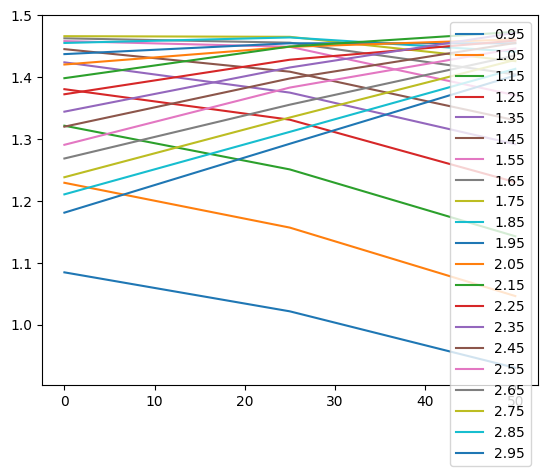

In [7]:
from scipy.optimize import curve_fit

os.system('rm *h5')

r_clad_out = 0.45
r_clad_in = 0.42
r_fuel = 0.41

pitch=[0.95,1.05,1.15,1.25,1.35,1.45,1.55,1.65,1.75,1.85,1.95,2.05,2.15,2.25,2.35,2.45,2.55,2.65,2.75,2.85,2.95]
void=[0,25,50]
all_keffs = []

results = [] #initialize lists to store results
for pi in pitch:
    #initialize list to store keff values
    keffs = []
    for v in void:
        #your code to call the pincell, run it, and store the k-effective comes here
        mod = pincell(pi,v,r_clad_out, r_clad_in, r_fuel)
        output = mod.run(output = False)
        sp = openmc.StatePoint(output)
        keffs.append(sp.keff.nominal_value)
        os.system('rm %s'%output)
        os.system('rm summary.h5')
    #your code to estimate the void-coefficient from a linear fit. and to store the data
    plt.plot(void, keffs, label = f"{pi}")
    plt.legend()
    linfunc = lambda x,a,b: a*x+b
    p, c = curve_fit(linfunc,void,keffs)
    results.append(p[0])
    all_keffs.append(keffs)

Alright, now we have the k-eigenvalue for several pitch and void values, and we have the void coefficient at several pitch values. It is time to visualize them somehow. Try to create a figure which shows the void coefficient vs the moderator to fuel ratio and an other figure which shows the k-eigenvalue vs the moderator to fuel ratio for each void levels.

Conclude your findings: how would you design a reactor core? which moderator to fuel ratio would you select?

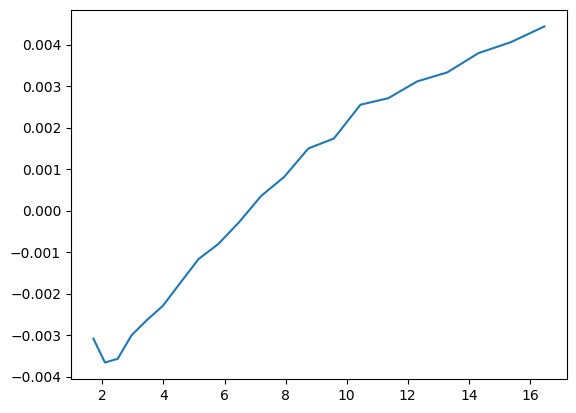

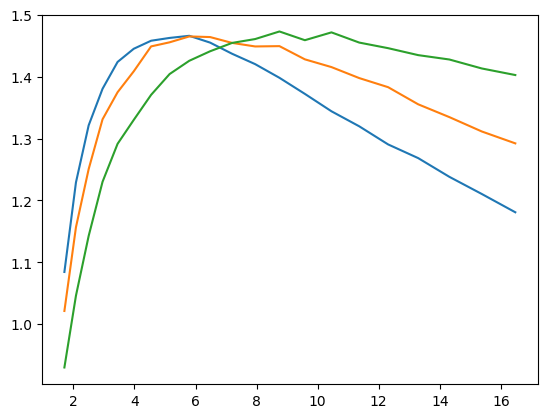

In [8]:
mfr= (np.array(pitch)**2 - (r_clad_out-r_clad_in)**2*np.pi)/(r_fuel**2*np.pi)
npall_keffs = np.array(all_keffs)

plt.figure()
plt.plot(mfr,results)
#your code comes here to visualize the void coefficient vs moderator to fuel ratio
plt.show()

plt.figure()
for i in range(len(all_keffs[0])):
	plt.plot(mfr,npall_keffs[:,i])
	#your code comes here to visualize the k-eigenvalue vs moderator to fuel ratio
plt.show()

Change this line to your conclusion!

## Experiment 3

Wow, we saw some interesting curve there, the k-infinity first increased with increasing the pitch and then it started to to decrease. Intuitively one expects that there are two competing physical phenonema at play here. And our intuition is correct. If you remember the 4-factor formula, there were two quantities which are of interest for us now to figure out why does the k-infinity change like this with the increasing pitch. And these two quantities are:

**Resonance escape probability**: probability for fast neutrons to slow-down to thermal energies without being absorbed in the resonance region of absorbers

$$p=1-\frac{\int_{V_{f}} \int_{\sim 5kT}^\infty \Sigma_a(r,E)\phi(r,E)dVdE}{\int_{V_{f}} \int_0^{\infty} \nu(E)\Sigma_f(r,E)\phi(r,E)dVdE}$$


**Thermal utilization factor**: the ratio of the number of thermal neutrons absorbed in the fuel and the number of thermal neutrons absorbed in all materials

$$f=\frac{\int_{V_{f}} \int_0^{\sim 5kT} \Sigma_a(r,E)\phi(r,E)dVdE}{\int_{V_{t}} \int_0^{\sim 5kT} \Sigma_a(r,E)\phi(r,E)dVdE}$$

The nominators and the denominators look like the expressions we used to define the tallies. The "scores" here are absorption, and nu-fission and the filters are the energy bounds and the spatial regions. So let's add these tallies to our `pincell()` function (for the tallies we will need to fix the ID, since we will refer to them later):

In [9]:
def pincell(pitch):
    r_clad_out = 0.45
    r_clad_in = 0.42
    r_fuel = 0.41
    
    #your input comes here, you can remove the void from your previous function
    uo2 = openmc.Material(name="uo2",temperature=1200)
    # Adding nuclides to uo2
    uo2.add_nuclide('U235', 0.04)
    uo2.add_nuclide('U238', 0.96)
    uo2.add_nuclide('O16', 2.0)
    uo2.set_density('g/cm3', 10.5)

    #cladding
    zirconium = openmc.Material(name="zirconium",temperature=900)
    zirconium.add_element('Zr', 1.0)
    zirconium.set_density('g/cm3', 6.6)
    
    #coolant    
    water = openmc.Material(name="h2o")
    water.add_nuclide('H1', 2.0)
    water.add_nuclide('O16', 1.0)
    water.set_density('g/cm3', 0.74)
    water.add_s_alpha_beta('c_H_in_H2O')

    mats = openmc.Materials([uo2, zirconium, water])
    mats.cross_sections = path


    fuel_or = openmc.ZCylinder(r=r_fuel) #fuel cylinder with outer radius
    clad_ir = openmc.ZCylinder(r=r_clad_in) #clad inner cylinder with inner radius
    clad_or = openmc.ZCylinder(r=r_clad_out) #clad outer cylinder with outer radius

    fuel_region = -fuel_or                  #inside the fuel cylinder
    gap_region = +fuel_or & -clad_ir      #outside of fuel cylinder and inside of clad inner cylinder
    clad_region = +clad_ir & -clad_or     #outside of clad inner cylinder and inside of clad outer cylinder

    fuel = openmc.Cell(name='fuel')
    fuel.fill = uo2
    fuel.region = fuel_region

    gap = openmc.Cell(name='air gap')
    gap.region = gap_region

    clad = openmc.Cell(name='clad')
    clad.fill = zirconium
    clad.region = clad_region

    pitch = pitch
    #we define the x and y planes with boundary condition
    left = openmc.XPlane(x0=-pitch/2, boundary_type='reflective')
    right = openmc.XPlane(x0=pitch/2, boundary_type='reflective')
    bottom = openmc.YPlane(y0=-pitch/2, boundary_type='reflective')
    top = openmc.YPlane(y0=pitch/2, boundary_type='reflective')

    #outside of left and inside of right, outside of bottom, and inside of top and outside of clad outer cylinder
    water_region = +left & -right & +bottom & -top & +clad_or

    moderator = openmc.Cell(name='moderator')
    moderator.fill = water
    moderator.region = water_region

    root = openmc.Universe(cells=(fuel, gap, clad, moderator))

    geom = openmc.Geometry()
    geom.root_universe = root

    point = openmc.stats.Point((0, 0, 0))
    src = openmc.Source(space=point)

    settings = openmc.Settings()
    settings.source = src
    settings.batches = 100
    settings.inactive = 10
    settings.particles = 500
    settings.output = {'tallies': False}

    #tallies
    T=1200
    k=8.617333262145e-5
    energy_filter = openmc.EnergyFilter([0., 5*k*T, 20.0e6])
    fuel_filter = openmc.CellFilter(fuel)
    moderator_filter = openmc.CellFilter(moderator)
    tally1 = openmc.Tally(1)
    tally1.filters = [fuel_filter,energy_filter]
    tally1.scores = ['absorption','nu-fission']
    
    tally2 = openmc.Tally(2)
    tally2.filters = [moderator_filter,energy_filter]
    tally2.scores = ['absorption']
    tallies = openmc.Tallies([tally1, tally2])
    model = openmc.model.Model(geom, mats, settings,tallies)
    return model

Now we just have to figure out how to compute $p$ and $f$ from the tallies. First it is best to remind ourselves how to load in the tally results, and you can do some trial and error to figure out these values. Let's run a computation with our model.

In [10]:
os.system('rm *h5')
mod=pincell(1.26)
output = mod.run()

rm: cannot remove '*h5': No such file or directory
/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

And now load in the tallies. And from there you can perform the necessary operations to obtain $p$ and $f$.

In [11]:
sp = openmc.StatePoint(output)
tallydf1 = sp.tallies[1].get_pandas_dataframe()
tallydf1

,cell,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,289,0.00000,5.170400e-01,total,absorption,0.563166,0.003745
1,289,0.00000,5.170400e-01,total,nu-fission,1.057360,0.007047
2,289,0.51704,2.000000e+07,total,absorption,0.388457,0.002089
3,289,0.51704,2.000000e+07,total,nu-fission,0.322238,0.001409


In [12]:
sp = openmc.StatePoint(output)
tallydf2 = sp.tallies[2].get_pandas_dataframe()
tallydf2

,cell,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,292,0.00000,5.170400e-01,total,absorption,0.031547,0.00023
1,292,0.51704,2.000000e+07,total,absorption,0.006199,0.00004


In [13]:
sp.tallies

{1: Tally
 	ID             =	1
 	Name           =	
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['absorption', 'nu-fission']
 	Estimator      =	tracklength
 	Multiply dens. =	True,
 2: Tally
 	ID             =	2
 	Name           =	
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['absorption']
 	Estimator      =	tracklength
 	Multiply dens. =	True}

In [14]:
tallydf1

,cell,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,289,0.00000,5.170400e-01,total,absorption,0.563166,0.003745
1,289,0.00000,5.170400e-01,total,nu-fission,1.057360,0.007047
2,289,0.51704,2.000000e+07,total,absorption,0.388457,0.002089
3,289,0.51704,2.000000e+07,total,nu-fission,0.322238,0.001409


In [15]:
tallydf2

,cell,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,292,0.00000,5.170400e-01,total,absorption,0.031547,0.00023
1,292,0.51704,2.000000e+07,total,absorption,0.006199,0.00004


$$p=1-\frac{\int_{V_{f}} \int_{\sim 5kT}^\infty \Sigma_a(r,E)\phi(r,E)dVdE}{\int_{V_{f}} \int_0^{\infty} \nu(E)\Sigma_f(r,E)\phi(r,E)dVdE}$$


**Thermal utilization factor**: the ratio of the number of thermal neutrons absorbed in the fuel and the number of thermal neutrons absorbed in all materials

$$f=\frac{\int_{V_{f}} \int_0^{\sim 5kT} \Sigma_a(r,E)\phi(r,E)dVdE}{\int_{V_{t}} \int_0^{\sim 5kT} \Sigma_a(r,E)\phi(r,E)dVdE}$$

In [21]:
#test here how p and f should be estimated
p = 1 - tallydf1["mean"][2]/(tallydf1["mean"][1]+tallydf1["mean"][3])
f = tallydf1["mean"][0]/(tallydf2["mean"][0]+tallydf1["mean"][0])
print(p)
print(f)

0.940372464571331
0.6458374136462686


Once we know how to get these quantities we can loop through several pitch values to see how they change with the moderator to fuel ratio!

In [24]:
pitch=[0.95,1.05,1.15,1.25,1.35,1.45,1.55,1.65,1.75,1.85,1.95,2.05,2.15,2.25,2.35,2.45,2.55,2.65,2.75,2.85,2.95]
os.system('rm *h5')
keff=[]
p=[]
f=[]
for pi in pitch:
    #create and run the model
    mod=pincell(pi)
    output = mod.run(output = False)
    
    #read the statepoint file and the tallies
    sp = openmc.StatePoint(output)
    tallydf1 = sp.tallies[1].get_pandas_dataframe()
    tallydf2 = sp.tallies[2].get_pandas_dataframe()

    keff.append(sp.keff.nominal_value)
    
    p.append(1 - tallydf1["mean"][2]/(tallydf1["mean"][1]+tallydf1["mean"][3]))
    f.append(tallydf1["mean"][0]/(tallydf2["mean"][0]+tallydf1["mean"][0])) 
       
    os.system('rm *h5')

rm: cannot remove '*h5': No such file or directory
/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Anoth

Finally we are ready to visualize our results and then conclude our findings. Try to summarize with few words the underlying physics what we just discovered here.

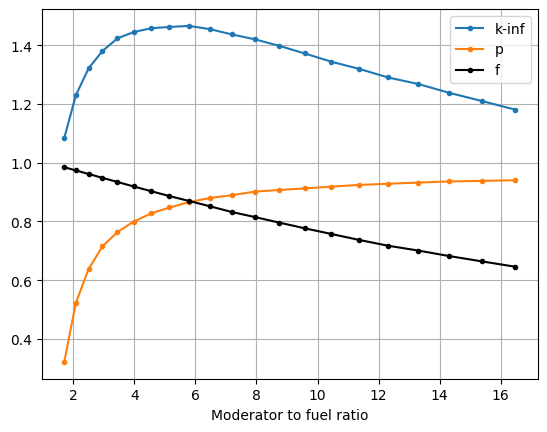

In [44]:
mfr=(np.array(pitch)**2 - (r_clad_out-r_clad_in)**2*np.pi)/(r_fuel**2*np.pi)

plt.figure()
plt.plot(mfr,keff,".-",label='k-inf')
plt.plot(mfr,p,".-",label='p')
plt.plot(mfr,f,"k.-",label='f')
# plt.plot(mfr,f,label='f')
plt.legend()
plt.xlabel('Moderator to fuel ratio')
plt.grid()
plt.show()

Change this line to your conclusions!